In [1]:
# https://www.tensorflow.org/install/source#gpu
! nvcc  --version

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import math
import wandb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from datetime import datetime

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from src.learning import get_laplace
from src.utils import (polar_transform, polar_transform_inv, apply_circular_mask, roll_batch, 
                       random_roll, log_biases, log_weights, log_gradients)
from src.visu import (plot_conv_filters, saliency_map, weighted_saliency_map, grad_cam, energy_map, 
                      plot_output_shift, process_until)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


2024-03-04 11:52:31.177155: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 11:52:31.177250: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 11:52:31.177273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 11:52:31.185129: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/project/johannsc/symmetries/RadialBeams/venv/lib/

Num GPUs Available:  1


2024-03-04 11:52:37.124113: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-03-04 11:52:37.125663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43606 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:03:00.0, compute capability: 8.6


In [2]:
config = {
    "dataset": 'stanford_dogs',
    "image_size": 100,
    "noise_factor": 0.1,
    "batch_size": 200,
    "n_filters": 64,
    "n_epochs": 250,
    "n_channels": 3,
    "n_classes": 1000,
    "learning_rate": 5e-4,
}
config |= {
    "radius": config["image_size"]//2, #- 5,
}
config |= {
    "len_beam": int(round(config['radius'])),
    "n_beams": int(round(config['radius']*2*np.pi))
}

wandb.init(project="RadialBeams", config=config, group=config['dataset'],
           name=datetime.now().strftime("%m%d-%H%M"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johschm. Use `wandb login --relogin` to force relogin


In [3]:
def preprocess(example):
    image = tf.cast(example['image'], tf.float32) / 255.
    image = tf.image.resize(image, [config['image_size'], config['image_size']], antialias=True)
    image = apply_circular_mask(image)
    return {
        'image': image,
        'label': example['label'],
        'polar': polar_transform(image, radius=config['radius'])
    }

def preprocess_test(example):
    example = preprocess(example)
    # random rotation angle
    k = tf.random.uniform(shape=(), minval=-config['n_beams'] // 2, maxval=config['n_beams'] // 2, dtype=tf.int64)
    angle = -tf.cast(k, tf.float32)*math.pi/(config['n_beams']//2)
    # resample + rotation
    polar_resrot = tf.roll(example['polar'], k, axis=1)
    # rotation + resample
    polar_rotres = tfa.image.rotate(example['image'], interpolation='bilinear', angles=angle)
    polar_rotres = polar_transform(polar_rotres, radius=config['radius'])
    return {
        'image': example['image'],
        'label': example['label'],
        'polar': example['polar'],
        'polar_resrot': polar_resrot,
        'polar_rotres': polar_rotres,
        'k': k,
        'angle': angle
    }

train_dataset = tfds.load(config['dataset'], split='train', shuffle_files=False)
test_dataset = tfds.load(config['dataset'], split='test', shuffle_files=False)

train_dataset = (train_dataset.map(preprocess, num_parallel_calls=8).cache()
                 .batch(config['batch_size']).prefetch(config['batch_size']))
test_dataset = (test_dataset.map(preprocess_test, num_parallel_calls=8).cache()
                .batch(config['batch_size']).prefetch(config['batch_size']))

train_dataset.save('./data/{}_train'.format(config['dataset']))
test_dataset.save('./data/{}_test'.format(config['dataset']))

train_dataset = tf.data.Dataset.load('./data/{}_train'.format(config['dataset']))
test_dataset = tf.data.Dataset.load('./data/{}_test'.format(config['dataset']))

next(iter(test_dataset))['polar'].shape

TensorShape([200, 50, 314, 3])

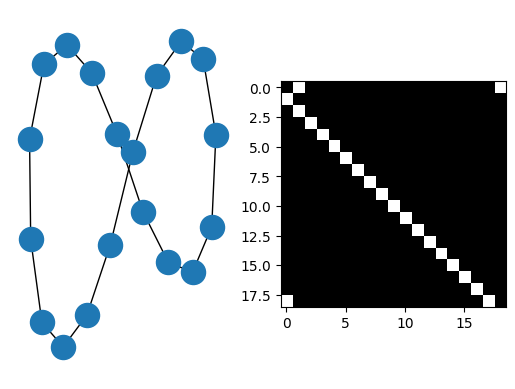

In [14]:
import networkx as nx

def circular_graph_adjacency_matrix(n_vectors):
    adjacency = np.zeros([n_vectors, n_vectors])
    adjacency[0, 1] = 1
    adjacency[0, n_vectors - 1] = 1
    for i in range(1, n_vectors - 1):
        adjacency[i, i-1] = 1
    adjacency[n_vectors - 1, n_vectors - 2] = 1
    adjacency[n_vectors - 1, 0] = 1
    return adjacency

A = circular_graph_adjacency_matrix(config['n_beams']//16)
G = nx.from_numpy_array(A)
fig, axs = plt.subplots(1,2)
nx.draw(G, ax=axs[0])
axs[1].imshow(A, cmap='grey')

In [16]:
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import activations
from tensorflow.keras import layers, models

class GraphConvolutionLayer(tf.keras.layers.Layer):

    def __init__(self, units, A, activation=tf.identity, rate=0.0, l2=0.0):
        super(GraphConvolutionLayer, self).__init__()
        self.activation = activation
        self.units = units
        self.rate = rate
        self.l2 = l2 
        self.A = A

    def build(self, input_shape):
        self.W = self.add_weight(
          shape=(input_shape[-1], self.units),
          dtype=self.dtype,
          name='gnn_weights',
          initializer='glorot_uniform',
          regularizer=tf.keras.regularizers.l2(self.l2)
        )

    def call(self, X):
        """
        input (batch x vector x hidden)
        output (batch x vector x hidden)
        """
        X = tf.nn.dropout(X, self.rate)
        X = self.A @ X @ self.W
        return self.activation(X)
    
class PolarRegressor(tf.keras.Model):
    """ Using Cyclic Feature Encoding.
    """
    
    def __init__(self, n_beams, len_beam, n_filters=128, n_channels=3, l2_bias=0.01):
        super().__init__()
        
        # This embeds each beam into a latent representation, mapping (C=3) -> (L)
        self.beam_encoding = None
        self.beam_encoder = models.Sequential([
            layers.InputLayer(input_shape=(len_beam, n_beams, n_channels)),
            layers.Dense(units=n_filters, activation='elu')
        ], name='enc0')
    
        # This encodes the polar representation of the image (batch x len_beams x n_beams+padding x channels)
        # down to an energy map of shape (batch x len_beams x n_beams x 1), which preservers translation-equivariance.
        self.latent_polar_map = None
        A = circular_graph_adjacency_matrix(n_beams)
        self.latent_polar_encoder = models.Sequential([
            layers.InputLayer(input_shape=(len_beam, n_beams, n_filters)),
            GraphConvolutionLayer(units=n_filters, A=A),
            GraphConvolutionLayer(units=n_filters, A=A),
            GraphConvolutionLayer(units=n_filters, A=A),
        ], name='enc0')
        
        self.latent_radial_energy = None
        self.latent_radial_energy_encoder = models.Sequential([
            layers.InputLayer(input_shape=(len_beam, n_beams, n_filters)),
            layers.Conv2D(n_filters, (9, 1), activation='elu', padding='valid', 
                          kernel_initializer=tf.keras.initializers.HeNormal(),
                          bias_initializer='zeros', bias_regularizer=tf.keras.regularizers.l2()),
            layers.Conv2D(n_filters, (9, 1), activation='elu', padding='valid', 
                          kernel_initializer=tf.keras.initializers.HeNormal(),
                          bias_initializer='zeros', bias_regularizer=tf.keras.regularizers.l2()),
            layers.LayerNormalization(center=False),
            
            layers.Conv2D(n_filters, (9, 1), activation='elu', padding='valid', 
                          kernel_initializer=tf.keras.initializers.HeNormal(),
                          bias_initializer='zeros', bias_regularizer=tf.keras.regularizers.l2()),
            layers.Conv2D(n_filters, (9, 1), activation='elu', padding='valid', 
                          kernel_initializer=tf.keras.initializers.HeNormal(),
                          bias_initializer='zeros', bias_regularizer=tf.keras.regularizers.l2()),
            layers.LayerNormalization(center=False),
        ], name='enc1')
        
        # This maps the transposed energy map (batch x n_beams x len_beams) down to a radial energy over S^1
        # of shape (batch x n_beams), which preservers translation-equivariance.
        self.radial_energy = None
        self.radial_energy_encoder = models.Sequential([
            layers.InputLayer(input_shape=(n_beams, n_filters)),
            layers.Dense(n_filters),
            layers.Dense(1),
        ], name='enc2')
    
    def call(self, x):
        self.beam_encoding = self.beam_encoder(x)
        # compute the energy map of the input
        self.latent_polar_map = self.latent_polar_encoder(self.beam_encoding)
        self.latent_radial_energy = self.latent_radial_energy_encoder(self.latent_polar_map)
        # from the energy map, we estimate an energy function over S^1
        # z = tf.transpose(self.energy_map, (0, 2, 1, 3)) # tf.squeeze(self.energy_map, axis=-1)
        self.radial_energy = self.radial_energy_encoder(tf.squeeze(self.latent_radial_energy))
        # we convolve this radial energy by a learned kernel 
        # z = self.angle_encoder(self.radial_energy)
        # normalise the angle vector 
        # return z / tf.norm(z, axis=-1, keepdims=True) 
        # log-probabilities
        return tf.nn.log_softmax(tf.squeeze(self.radial_energy, axis=-1), axis=-1)


model = PolarRegressor(len_beam=config['len_beam'], n_beams=config['n_beams'],
                       n_channels=config['n_channels'], n_filters=config['n_filters'])
model.build(input_shape=(config['batch_size'], config['len_beam'], config['n_beams'], config['n_channels']))
model(tf.zeros((config['batch_size'], config['len_beam'], config['n_beams'], config['n_channels'])))
model.summary()

ValueError: Input 0 of layer "enc2" is incompatible with the layer: expected shape=(None, 314, 64), found shape=(200, 18, 314, 64)